# Keck HIRES multi-epoch

Multiple visits to the same object

In [1]:
import pandas as pd
import numpy as np
import glob
import astropy
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm.notebook import tqdm

#import warnings
#warnings.simplefilter("ignore")

In [2]:
from muler.hires import KeckHIRESSpectrum, KeckHIRESSpectrumList

In [3]:
search_pattern = '../../../muler_example_data/Keck_HIRES/02_multi_epoch/**/extracted/binaryfits/ccd*/flux/HI.*_flux.fits.gz'

In [4]:
fns = sorted(glob.glob(search_pattern, recursive=True))

In [5]:
len(fns)

774

In [6]:
import os

In [7]:
basenames = [os.path.basename(fn) for fn in fns]

In [8]:
df = pd.DataFrame(data={'basename':basenames, 'full_path':fns})

In [9]:
df['median_wl'] = np.NaN
df['min_wl'] = np.NaN
df['max_wl'] = np.NaN
df['ccd'] = np.NaN #CCDLOC
df['decker'] = '' # DECKNAME
df['iodine'] = False # IODIN
df['MJD'] = False # IODIN

In [10]:
spec = KeckHIRESSpectrum(file=fns[0])

In [11]:
for i, fn in enumerate(tqdm(df.full_path.values, total=len(df)) ):
    spec = KeckHIRESSpectrum(file=fn)
    df.loc[i, 'median_wl'] = np.nanmedian(spec.wavelength.value)
    df.loc[i, 'min_wl'] = np.nanmin(spec.wavelength.value)
    df.loc[i, 'max_wl'] = np.nanmax(spec.wavelength.value)
    df.loc[i, 'ccd'] = int(spec.meta['header']['CCDLOC'])
    df.loc[i, 'decker'] = spec.meta['header']['DECKNAME']
    df.loc[i, 'MJD'] = spec.meta['header']['MJD']
    df.loc[i, 'iodine'] = spec.meta['header']['IODIN']

  0%|          | 0/774 [00:00<?, ?it/s]

### Make a comparison sample from Specmatch-Empirical F-stars

In [12]:
search_pattern = '../../../muler_example_data/Keck_HIRES/03_reference_stars/**/extracted/binaryfits/ccd*/flux/HI.*_flux.fits.gz'
fns = sorted(glob.glob(search_pattern, recursive=True))
len(fns)

265

In [13]:
basenames = [os.path.basename(fn) for fn in fns]

In [14]:
df_comp = pd.DataFrame(data={'basename':basenames, 'full_path':fns})
df_comp['median_wl'] = np.NaN
df_comp['min_wl'] = np.NaN
df_comp['max_wl'] = np.NaN
df_comp['ccd'] = np.NaN #CCDLOC
df_comp['decker'] = '' # DECKNAME
df_comp['iodine'] = False # IODIN
df_comp['MJD'] = False # IODIN

In [15]:
for i, fn in enumerate(tqdm(df_comp.full_path.values, total=len(df_comp)) ):
    spec = KeckHIRESSpectrum(file=fn)
    df_comp.loc[i, 'median_wl'] = np.nanmedian(spec.wavelength.value)
    df_comp.loc[i, 'min_wl'] = np.nanmin(spec.wavelength.value)
    df_comp.loc[i, 'max_wl'] = np.nanmax(spec.wavelength.value)
    df_comp.loc[i, 'target'] = spec.meta['header']['TARGNAME']
    df_comp.loc[i, 'decker'] = spec.meta['header']['DECKNAME']
    df_comp.loc[i, 'MJD'] = spec.meta['header']['MJD']
    df_comp.loc[i, 'iodine'] = spec.meta['header']['IODIN']

  0%|          | 0/265 [00:00<?, ?it/s]

In [16]:
df.decker.value_counts()

C2    430
B5    344
Name: decker, dtype: int64

In [17]:
df_comp.decker.value_counts()

B5    143
C1     87
C2     35
Name: decker, dtype: int64

Only two decker settings:

|Decker| H(") | W(")| R|
|-- | -- | -- | -- |
B5 |	3.5 |	0.861 |	48,000 | 
C2 | 14.0 |	0.861 |	48,000 | 

Let's pick some spectral indices

In [18]:
df_comp.target.value_counts()

173667     106
hr_7061     87
3684        37
6210        35
Name: target, dtype: int64

In [19]:
from gollum.phoenix import PHOENIXSpectrum

In [20]:
template_raw = PHOENIXSpectrum(teff=6400, logg=4.0, wl_lo=3700, wl_hi=9000)
template = template_raw.divide_by_blackbody()
template = template.normalize()
continuum_fit = template.fit_continuum(polyorder=5)
template = template.divide(continuum_fit, handle_meta='ff')

In [21]:
template = template.rotationally_broaden(35.0).instrumental_broaden(55_000)

In [22]:
feature_wl = 6563 #H-alpha, etc

(6523.0, 6613.0)

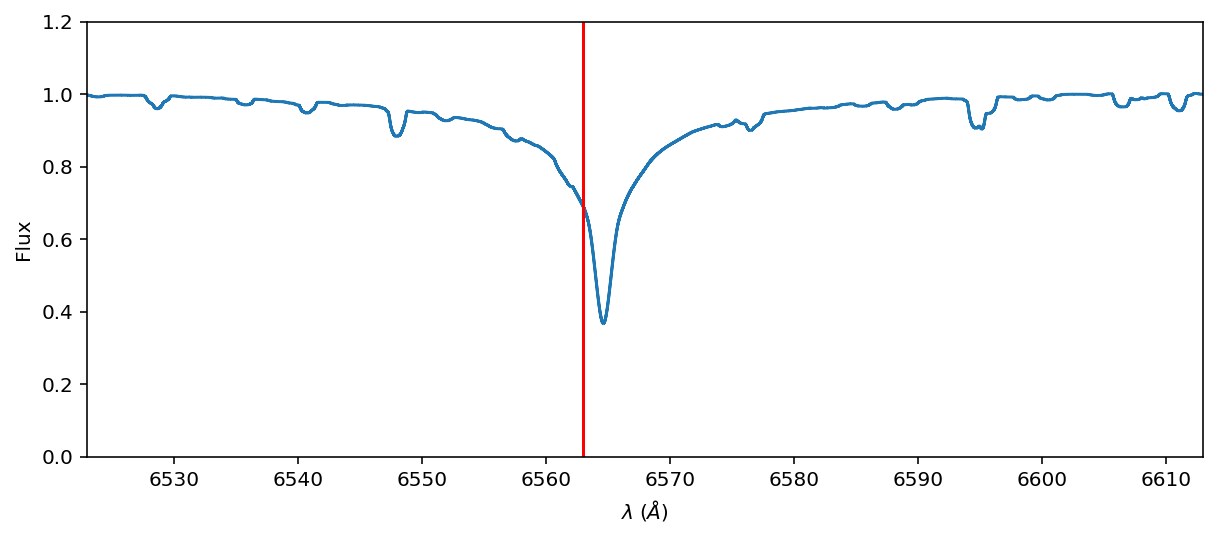

In [23]:
ax = template.plot(ylo=0)
ax.axvline(feature_wl, color='r')

ax.set_xlim(feature_wl-40, feature_wl+50)

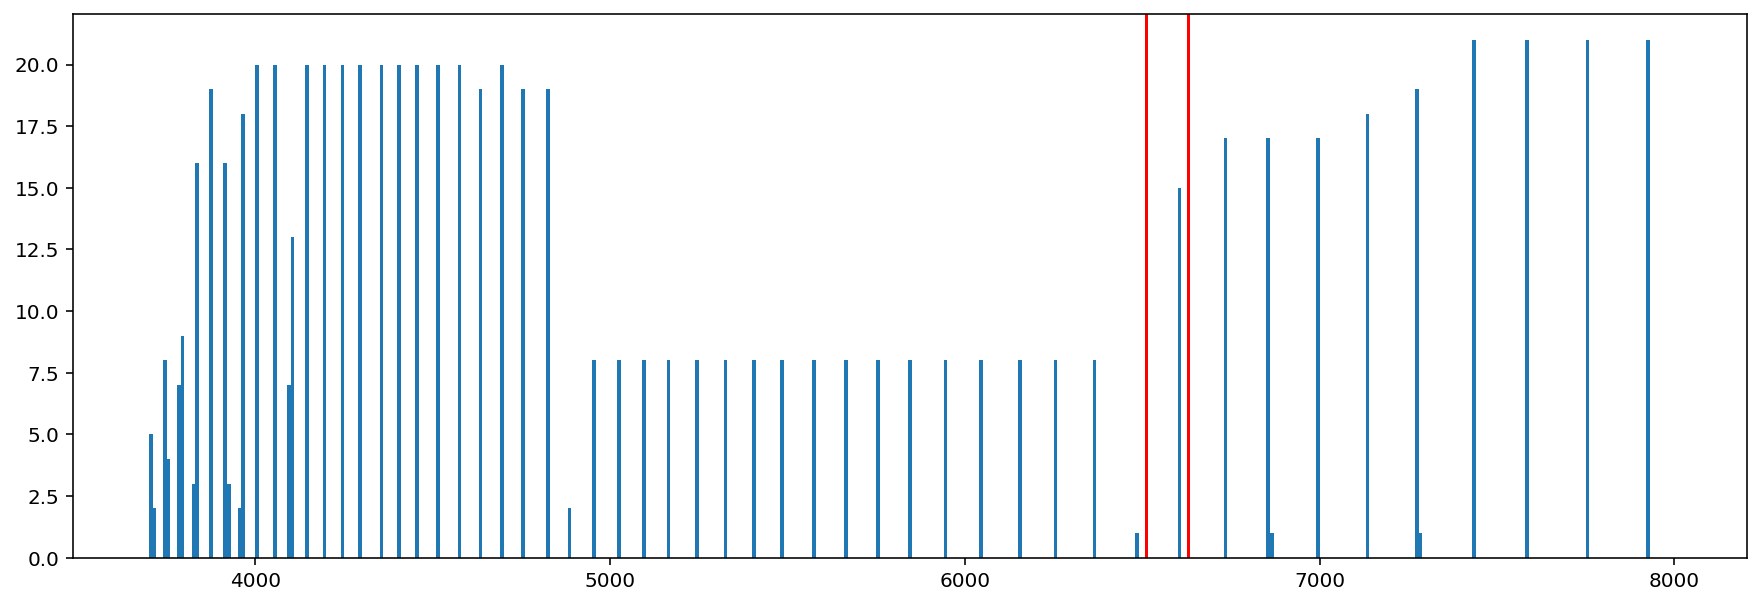

In [28]:
plt.figure(figsize=(15, 5))
plt.hist(df.median_wl, bins=np.arange(3700, 8000, 10));

plt.axvline(6510, color='r');plt.axvline(6630, color='r')

Let's spot check each spectrum:

In [24]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

  0%|          | 0/15 [00:00<?, ?it/s]

0 0.14026232710075298
1 0.13851545944977578
2 0.14154513008964695
3 0.13971017406826763
4 0.1482433657984292
5 0.14351494433597084
14 0.14116854027458328


  0%|          | 0/2 [00:00<?, ?it/s]

0 0.1456017943085332
1 0.15421022497788092


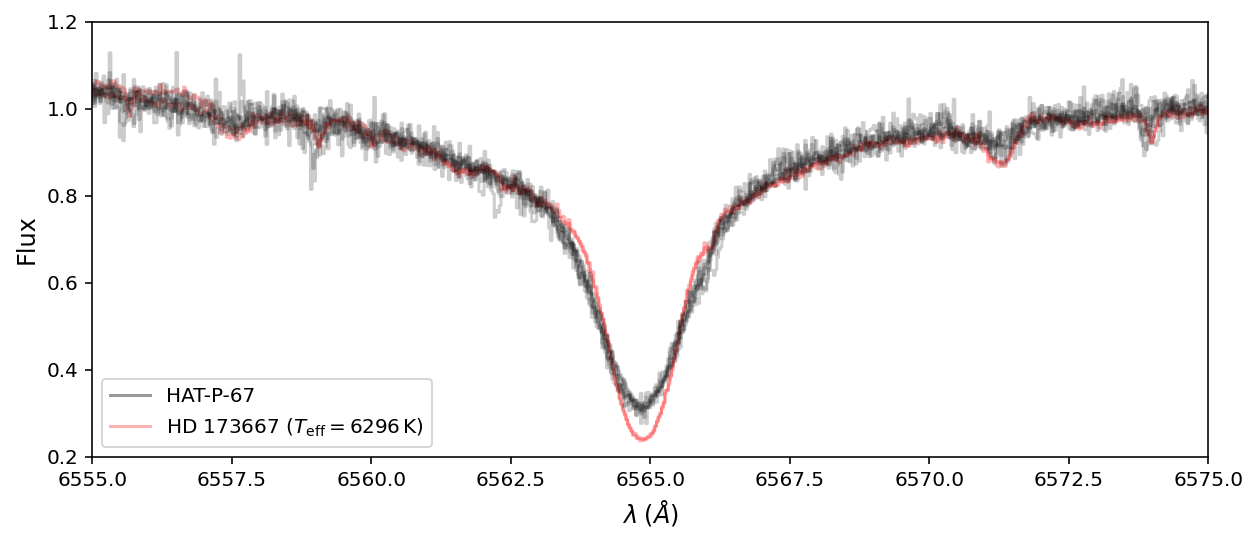

In [46]:
df_subset = df[(df.median_wl>6510) & (df.median_wl<6630)].reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
for i, fn in enumerate(tqdm(df_subset.full_path.values, total=len(df_subset)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec = spec_raw.normalize().barycentric_correct()
    mask = (spec.wavelength>6545*u.AA) & (spec.wavelength<6590*u.AA)
    spec = spec.apply_boolean_mask(mask).normalize()
    if df_subset.iloc[i].decker=='B5' and (spec.flux.std().value<0.50):
        spec.rv_shift(20.4).plot(ax=ax, alpha=0.2, color='k')
        print(i, spec.flux.std())
ax.plot(-1, -2, color='k',alpha=0.4, label='HAT-P-67')
        
df_subset = df_comp[(df_comp.median_wl>6510) & (df_comp.median_wl<6630)].reset_index()

targ = 'HD 173667 ($T_\mathrm{eff}=6296\,$K)'
for i, fn in enumerate(tqdm(df_subset.full_path.values, total=len(df_subset)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec = spec_raw.normalize().barycentric_correct()
    mask = (spec.wavelength>6545*u.AA) & (spec.wavelength<6590*u.AA)
    spec = spec.apply_boolean_mask(mask).normalize()
    target = spec.meta['header']['TARGNAME']
    if target == '173667':
        spec.rv_shift(-28.0).plot(ax=ax, alpha=0.3, color='r', label=targ, zorder=-10)
        targ = None
    print(i, spec.flux.std())        
        
#template.resample(spec).normalize().plot(ax=ax, label='PHOENIX ($T_\mathrm{eff}=6400\,$K)')
ax.set_ylim(0.2, 1.2)
ax.legend()
ax.set_xlim(6555, 6575)
#ax.set_xlim(6562, 6567.5)
ax.set_ylabel('Flux', fontsize=12)
ax.set_xlabel('$\lambda \;(\AA)$', fontsize=12)
plt.savefig('../../paper/paper1/figures/Keck_HIRES_Ha_comparison.png', bbox_inches='tight', dpi=300)
#ax.axvline(6563, color='k', linestyle='dashed')

In [37]:
len(MJDs)

22

  0%|          | 0/27 [00:00<?, ?it/s]

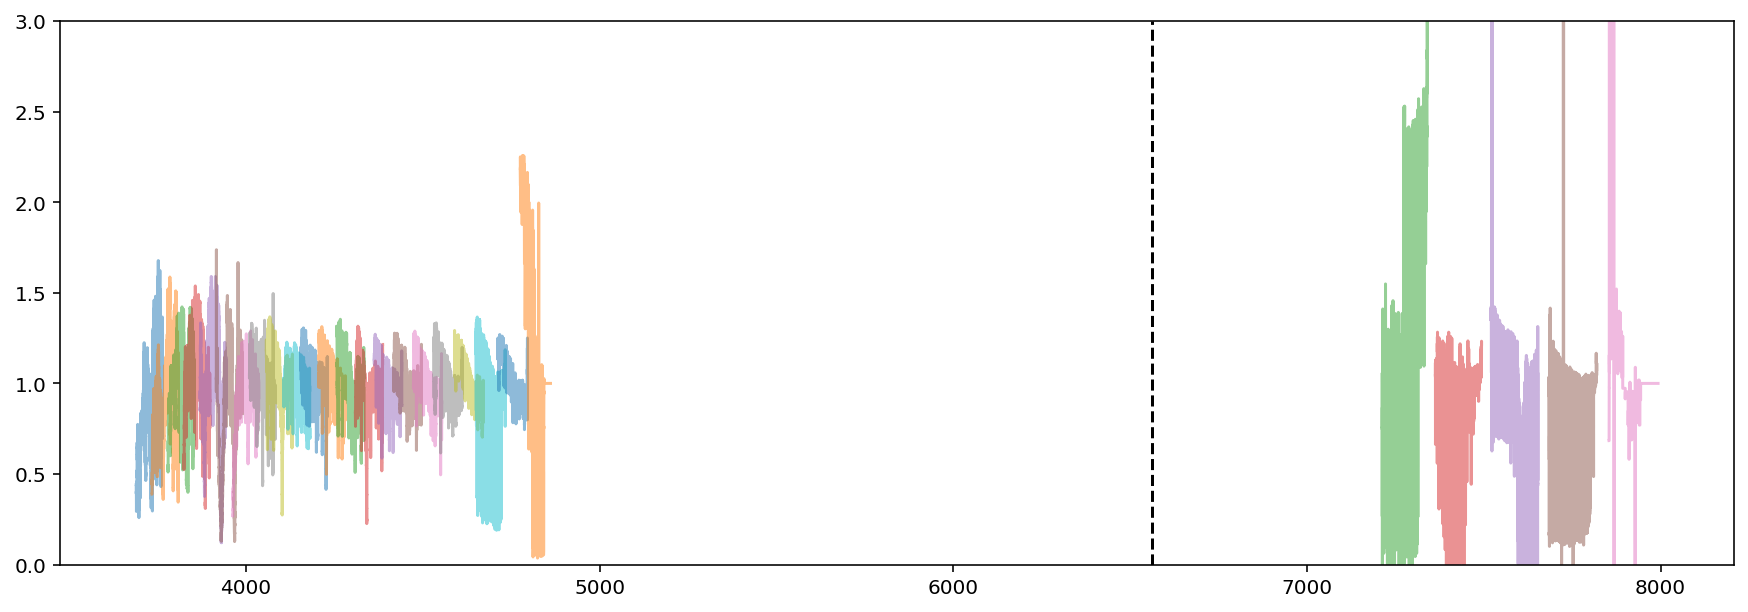

In [38]:
df_subset = df[df.MJD == MJDs[13]].reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
for i, fn in enumerate(tqdm(df_subset.full_path.values, total=len(df_subset)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec = spec_raw.normalize()
    spec.plot(ax=ax, alpha=0.5)
ax.set_ylim(0, 3)
#ax.set_xlim(7500, 8000)
ax.axvline(6563, color='k', linestyle='dashed')

In [39]:
df = df.sort_values('median_wl').reset_index(drop=True)

In [40]:
mask = (df.min_wl < feature_wl) & (df.max_wl > feature_wl) 

In [41]:
df = df[mask].reset_index(drop=True)

In [42]:
len(df)

20

In [43]:
df.iodine.value_counts()

True     18
False     2
Name: iodine, dtype: int64

In [44]:
df['corrupt'] = False

for i, fn in enumerate(tqdm(df.full_path.values, total=len(df)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec = spec_raw.normalize()
    if np.std(spec.flux.value) > 0.35:
        df.loc[i, 'corrupt'] = True

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
df[['basename', 'MJD', 'iodine', 'corrupt']]

,basename,MJD,iodine,corrupt
0,HI.20090801.38530_1_16_flux.fits.gz,55044.445976,True,False
1,HI.20091003.19231_1_13_flux.fits.gz,55107.222602,False,False
2,HI.20091003.18871_1_16_flux.fits.gz,55107.218429,True,False
3,HI.20090730.33446_1_16_flux.fits.gz,55042.387124,True,False
4,HI.20090731.42897_1_13_flux.fits.gz,55043.496523,True,False
5,HI.20090704.43633_1_14_flux.fits.gz,55016.505035,True,False
6,HI.20111019.18223_1_22_flux.fits.gz,55853.210939,True,False
7,HI.20110524.30567_1_17_flux.fits.gz,55705.353804,True,False
8,HI.20110526.29898_1_17_flux.fits.gz,55707.346057,True,False
9,HI.20110516.28232_1_17_flux.fits.gz,55697.326782,True,False


  0%|          | 0/20 [00:00<?, ?it/s]

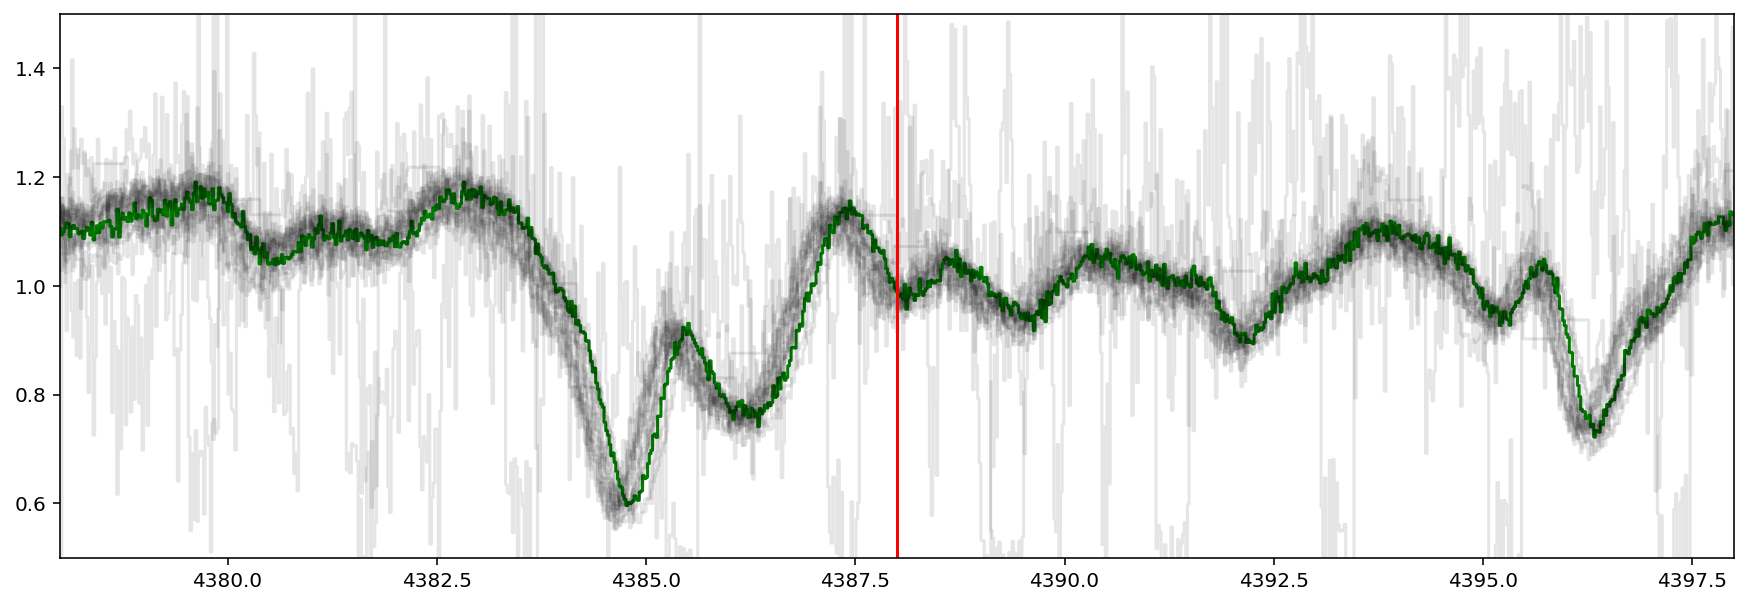

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
for i, fn in enumerate(tqdm(df.full_path.values, total=len(df)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec_cln = spec_raw.subtract(spec_raw.sky, handle_meta='ff')
    
    spec = spec_raw.barycentric_correct()
    spec = spec.normalize()
    #print(i, np.std(spec.flux.value), spec.estimate_barycorr())
    if ~df.loc[i, 'corrupt']:
        spec.plot(ax=ax, color='k', alpha=0.1)
    
    if i==7:
        spec.plot(ax=ax, color='g')
    
ax.set_xlim(feature_wl-10, feature_wl+10)
ax.set_ylim(0.5, 1.5)
ax.axvline(feature_wl, color='r')
ax.axvline(4472, color='b')

The velocity rest frame appears off!  Let's cross-correlate for good measure...

In [47]:
from specutils.analysis import correlation

  0%|          | 0/20 [00:00<?, ?it/s]

-12.032042766741183 km / s
-5.347630897901781 km / s
-5.347630896670286 km / s
-4.0107291035241435 km / s
-4.010731750273192 km / s
0.0 km / s
-5.347677131519578 km / s
3.970020533875163 km / s
-2.6875653207063084 km / s
-1.3369746465271137 km / s
0.0 km / s
-2.6875711298679774 km / s
1.3369792402697742 km / s
-2.6875591449585294 km / s
0.0 km / s
641.0965133421248 km / s
2.673968276183703 km / s
5.348078438898689 km / s
13.370460779640345 km / s
6.685184753743725 km / s


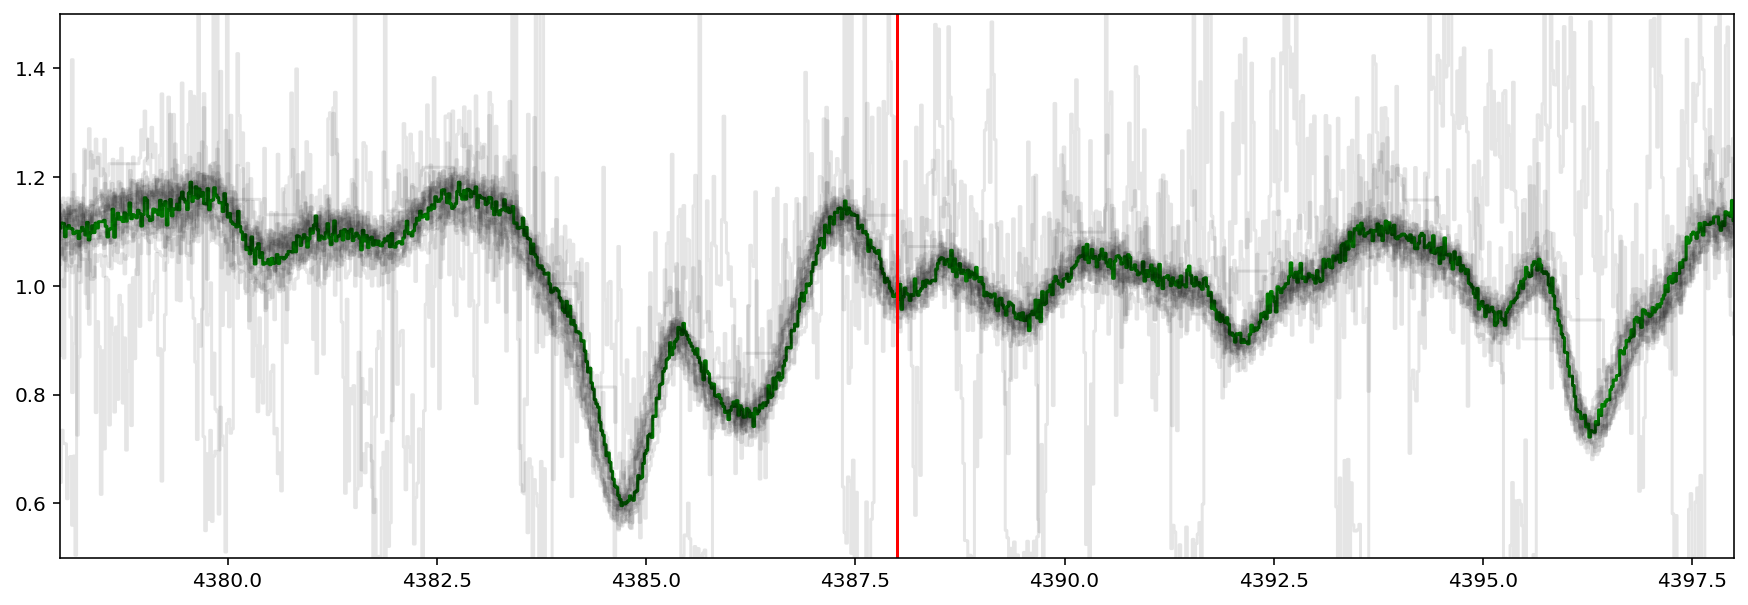

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
for i, fn in enumerate(tqdm(df.full_path.values, total=len(df)) ):
    spec_raw = KeckHIRESSpectrum(file=fn)
    spec_cln = spec_raw.subtract(spec_raw.sky, handle_meta='ff')
    
    spec = spec_raw.barycentric_correct()
    spec = spec.normalize()
    #print(i, np.std(spec.flux.value), spec.estimate_barycorr())
    mask = (spec.wavelength > 4380*u.AA) & (spec.wavelength < 4395*u.AA)

    ospec = spec.apply_boolean_mask(mask).normalize()
    ospec.rest_value = feature_wl * u.AA
    tspec = template.resample(ospec).normalize()

    corr, lag = correlation.template_correlate(ospec, tspec)

    max_ind = np.argmax(corr)

    delta_RV = lag[max_ind]
    print(delta_RV)
    if ~df.loc[i, 'corrupt']:
        spec.rv_shift(-1*delta_RV).plot(ax=ax, color='k', alpha=0.1)
    
    if i==7:
        spec.rv_shift(-1*delta_RV).plot(ax=ax, color='g', alpha=1)
    
ax.set_xlim(feature_wl-10, feature_wl+10)
ax.set_ylim(0.5, 1.5)
ax.axvline(feature_wl, color='r')
ax.axvline(4472, color='b')